# Introduction to the Ideal Binary Mask

### This file uses two speech files as an input, and uses an Ideal Binary Mask to separate them again. 

In [8]:
from scipy import signal
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
from math import ceil
import sounddevice as sd
from sphfile import SPHFile

In [14]:
file1 = "./SA1.wav"
file2 = "./SA2.wav"

## 1. Transfer SPHFile to wav

In [11]:
sph1 = SPHFile('TIMIT/SA1.WAV')
sph1.write_wav('SA1.wav')

'SA1.wav'

In [12]:
sph2 = SPHFile('TIMIT/SA2.WAV')
sph2.write_wav('SA2.wav')

'SA2.wav'

## 2. The two speech files are both padded with zeros to make them the same length, and further padded to pad the length to the nearest whole second. This was done to make implementing the STFT and iSTFT easier.

In [15]:
# Read 2 wav files; rate:16000Hz; samples:not belong to [0,1]
sample_rate1, samples1 = wavfile.read(file1)
sample_rate2, samples2 = wavfile.read(file2)

In [25]:
# Find length of longest signal
maxlength = max(len(samples1),len(samples1))  # 53556

# Pad each signal to the length of the longest signal
samples1 = np.pad(samples1, (0, maxlength - len(samples1)), 'constant', constant_values=(0))
samples2 = np.pad(samples2, (0, maxlength - len(samples2)), 'constant', constant_values=(0))

# Combine series together
mixed_series = samples1 + samples2

In [29]:
# Play the mixed speech
sd.play(mixed_series, sample_rate1)

In [30]:
# Pad 3 wav files to whole number of seconds
extrapadding = ceil(len(mixed_series) / sample_rate1) * sample_rate1 - len(mixed_series)
mixed_series = np.pad(mixed_series, (0, extrapadding), 'constant', constant_values=(0))
samples1 = np.pad(samples1, (0,extrapadding), 'constant', constant_values=(0))
samples2 = np.pad(samples2, (0,extrapadding), 'constant', constant_values=(0))

In [34]:
# Play and save the mixed speech
sd.play(mixed_series, sample_rate1)
#wavfile.write('mixed.wav', sample_rate1, np.asarray(mixed_series, dtype=np.int16))

<Figure size 432x288 with 0 Axes>

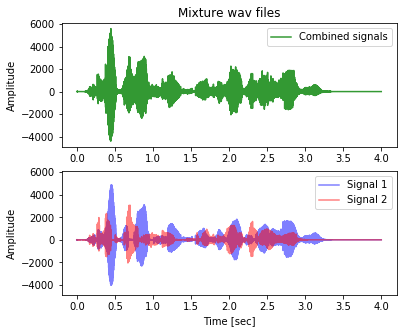

In [37]:
# Show 3 wav files in plot
x = np.arange(0, (len(mixed_series) / sample_rate1), (1 / sample_rate1))

#Show wav file on chart
fig = plt.figure()
fig, (ax1, ax2) = plt.subplots(2, figsize=(6,5), sharey=True)

ax1.plot(x, mixed_series, color="green", alpha = 0.8)
ax1.set(title='Mixture wav files', ylabel='Amplitude')
ax1.legend(['Combined signals'])

ax2.plot(x, samples1, color="blue", alpha = 0.5)
ax2.plot(x, samples2, color="red", alpha = 0.5)
ax2.set(xlabel='Time [sec]', ylabel='Amplitude')
ax2.legend(['Signal 1', 'Signal 2'])

#fig.savefig("mixturesignals.png", bbox_inches="tight")
plt.show()
plt.close(fig)

In [38]:
# Compute the STFT of the 3 wav files
nperseg = sample_rate1 / 50  # Length of each segment. Defaults to 256. Set to 0.05 of a second

#Get stft of 3 wav files
f1, t1, Zsamples1 = signal.stft(samples1, fs=sample_rate1, nperseg=nperseg)
f2, t2, Zsamples2 = signal.stft(samples2, fs=sample_rate1, nperseg=nperseg)
fmixed, tmixed, Zmixed_series = signal.stft(mixed_series, fs=sample_rate1, nperseg=nperseg)

<Figure size 432x288 with 0 Axes>

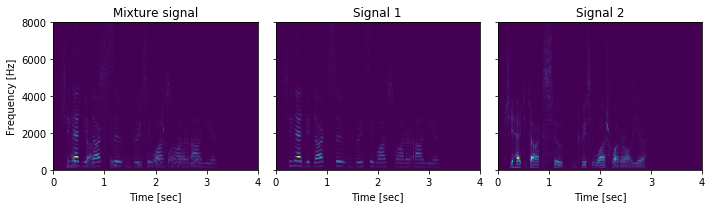

In [39]:
#%% Plot magnitude spectrogram of 3 wav files
fig = plt.figure() 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3), sharey=True)

ax1.pcolormesh(tmixed, fmixed, np.abs(Zmixed_series))
ax1.set(title='Mixture signal', xlabel='Time [sec]', ylabel='Frequency [Hz]')

ax2.pcolormesh(t1, f1, np.abs(Zsamples1))
ax2.set(title='Signal 1', xlabel='Time [sec]')

ax3.pcolormesh(t2, f2, np.abs(Zsamples2))
ax3.set(title='Signal 2', xlabel='Time [sec]')

plt.tight_layout()
#fig.savefig("spectrograms.png", bbox_inches="tight")
plt.show()
plt.close(fig)

## 3. Create IBM for signal 1 by calculating SNR of signal 1 vs mixture signal

### A mask was then calculated using the SNR of the absolute value of the STFT of the clean signal of one of the speech signals (speaker 2) divided by the absolute value of the STFT of the mixture signal. An IBM was created rounding this mask to the nearest integer and then applying a ceiling function so that any number greater than 1 was given the value 1.

In [86]:
import warnings
warnings.filterwarnings('ignore')

# Calculate signal to noise ratio of clean signal versus combined signal (for speaker 2)
snr2 = np.divide(np.abs(Zsamples2), np.abs(Zmixed_series))  # dividing denominator may be 0, so there will be nan
snr2

array([[0.1628723 , 0.33648875, 0.4496353 , ...,        nan,        nan,
               nan],
       [0.15258941, 0.40417036, 0.41113153, ...,        nan,        nan,
               nan],
       [0.20557386, 0.67476964, 0.5124027 , ...,        nan,        nan,
               nan],
       ...,
       [0.528545  , 0.7404754 , 1.2975628 , ...,        nan,        nan,
               nan],
       [0.47411957, 1.2847348 , 0.9551614 , ...,        nan,        nan,
               nan],
       [0.48634914, 7.549913  , 1.544811  , ...,        nan,        nan,
               nan]], dtype=float32)

In [87]:
# Round snr to 0 or 1 to create binary mask
mask2 = np.around(snr2, 0)
mask2

array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  1.,  1., ..., nan, nan, nan],
       ...,
       [ 1.,  1.,  1., ..., nan, nan, nan],
       [ 0.,  1.,  1., ..., nan, nan, nan],
       [ 0.,  8.,  2., ..., nan, nan, nan]], dtype=float32)

In [88]:
# Convert all nan in mask to 1 (it shouldnt matter if this is 0 or 1)
mask2[np.isnan(mask2)] = 1
 
# Replace all values over 1 with 1
mask2[mask2 > 1] = 1
mask2

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [89]:
# Check to see what maximum value in array is
np.amax(mask2)

1.0

## 4. Speech recovery

### The mixture signal is then combined with the mask using element-wise multiplication (Hadamard product). An iSTFT is then applied to the resulting array to obtain the original speech signal.

In [90]:
# Computer two masks of two speakers
mask1 = 1 - mask2  # speaker 1

In [91]:
# Element-wise multiply mask with mixed signal t-f signal
Zsamplesmaked1 = np.multiply(Zmixed_series, mask1)
Zsamplesmaked2 = np.multiply(Zmixed_series, mask2)

<Figure size 432x288 with 0 Axes>

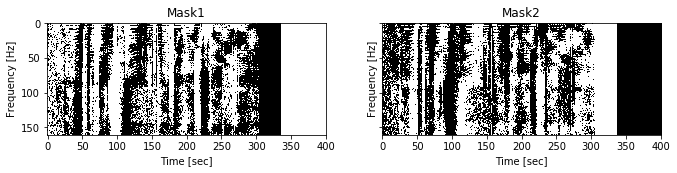

In [92]:
# Show mask
fig = plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 8), sharey=True)

ax1.imshow(mask1, cmap='Greys', interpolation='none')
ax1.set(title='Mask1', xlabel='Time [sec]', ylabel='Frequency [Hz]')

ax2.imshow(mask2, cmap='Greys', interpolation='none')
ax2.set(title='Mask2', xlabel='Time [sec]', ylabel='Frequency [Hz]')

#fig.savefig("masks.png", bbox_inches="tight")
plt.show()
plt.close(fig)

In [93]:
# Convert back to a time series via inverse STFT, uses the phase spectrum of the mixed speech
_, samplesrec1 = signal.istft(Zsamplesmaked1, sample_rate1)  # speaker 1
_, samplesrec2 = signal.istft(Zsamplesmaked2, sample_rate2)  # speaker 2

In [99]:
# Play the recovered speech1
sd.play(samplesrec1, sample_rate1)

In [98]:
# Play the recovered speech2
sd.play(samplesrec2, sample_rate2)

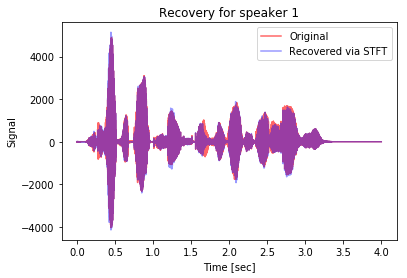

In [144]:
# Compare the original wav with recovered wav (speaker 1)
fig = plt.figure()
plt.plot(x, samples1, color="red", alpha = 0.6)
plt.plot(x, samplesrec1, color="blue", alpha = 0.4)
plt.title("Recovery for speaker 1")
plt.xlabel('Time [sec]')
plt.ylabel('Signal')
plt.legend(['Original', 'Recovered via STFT'])

#fig.savefig("recoverd1.png", bbox_inches="tight")
plt.show()
plt.close(fig)

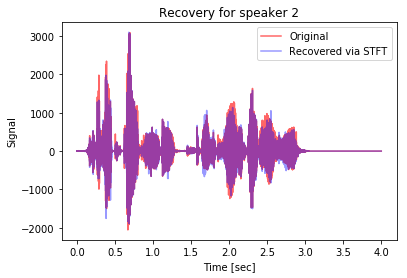

In [145]:
# Compare the original wav with recovered wav (speaker 2)
fig = plt.figure()
plt.plot(x, samples2, color="red", alpha = 0.6)
plt.plot(x, samplesrec2, color="blue", alpha = 0.4)
plt.title("Recovery for speaker 2")
plt.xlabel('Time [sec]')
plt.ylabel('Signal')
plt.legend(['Original', 'Recovered via STFT'])

#fig.savefig("recoverd2.png", bbox_inches="tight")
plt.show()
plt.close(fig)

### Reference
* [simonsuthers/IBM-Separation](https://github.com/simonsuthers/IBM-Separation)
* [MPM14-Time-Frequency-Masking.pdf](http://www.cs.northwestern.edu/~pardo/courses/eecs352/lectures/MPM14-Time-Frequency-Masking.pdf)